# Assignment 2: Text Classification with Various Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Deep Weighted Averaging Networks using Attention, and BERT-based models. You should also be able to develop an intuition for:


*   The effects of fine-tuning word vectors or starting with random word vectors
*   How various networks behave when the training set size changes
* The effect of shuffling your training data
*   The benefits of Attention calculations
* Working with BERT


The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

The initial part of the notebook is purely setup. We will then evaluate how Attention can make Deep Averaging networks better. 

Do not try to run this entire notebook on your GCP instance as the training of models requires a GPU to work in a timely fashion. This notebook should be run on a Google Colab leveraging a GPU. By default, when you open the notebook in Colab it will try to use a GPU. Total runtime of the entire notebook (with solutions and a Colab GPU) should be about 1h.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/assignment/a2/Text_classification.ipynb)

The overall assignment structure is as follows:

1. Setup
  
  1.1 Libraries, Embeddings,  & Helper Functions

  1.2 Data Acquisition

  1.3. Data Preparation

      1.3.1 Training/Test Sets using Word2Vec 

      1.3.2 Training/Test Sets for BERT-based models

2. Classification with various Word2Vec-based Models

  2.1 The Role of Shuffling of the Training Set

  2.2 DAN vs Weighted Averaging Models using Attention

    2.2.1 Warm-Up
    
    2.2.2 The WAN Model
    
  2.3 Approaches for Training of Embeddings 

3. Classification with BERT

  3.1. BERT Basics

  3.2 CLS-Token-based Classification 

  3.3 Averaging of BERT Outputs

  3.4. Adding a CNN on top of BERT



**INSTRUCTIONS:**: 

* Questions are always indicated as **QUESTION**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1.  Please do **not** remove the output from your notebooks when you submit them as we'll look at the output as well as your code for grading purposes.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 1 in bulk. This is setup work and no questions are in there. At the end of section 1 we will state all of the relevant variables that were defined and created in section 1.

* Finally, unless otherwise indicated your validation accuracy will be 0.65 or higher if you have correctly implemented the model.



## 1. Setup

### 1.1. Libraries and Helper Functions

This notebook requires the TensorFlow dataset and other prerequisites that you must download. 

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet

     |████████████████████████████████| 24.2 MB 1.4 MB/s 
     |████████████████████████████████| 4.9 MB 15.8 MB/s 
     |████████████████████████████████| 4.9 MB 15.6 MB/s 
     |████████████████████████████████| 6.6 MB 48.5 MB/s 
     |████████████████████████████████| 120 kB 75.3 MB/s 


Now we are ready to do the imports.

In [2]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Below is a helper function to plot histories.

In [3]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)

    # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
    if 'classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['classification_accuracy'])
    else:
      ax4.plot(history2.history['accuracy'])
    
    if 'val_classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['val_classification_accuracy'])
    else:
      ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

Next, we get the word2vec model from nltk.

In [4]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


Now here we have the embedding **model** defined, let's see how many words are in the vocabulary:

In [5]:
len(model.vocab)

43981

What do the word vectors look like? As expected:

In [6]:
model['great'][:20]

array([ 0.0306035 ,  0.0886877 , -0.0121269 ,  0.0761965 ,  0.0566269 ,
       -0.0424702 ,  0.0410129 , -0.0497567 , -0.00364328,  0.0632889 ,
       -0.0142608 , -0.0791111 ,  0.0174877 , -0.0383064 ,  0.00926433,
        0.0295626 ,  0.0770293 ,  0.0949334 , -0.0428866 , -0.0295626 ],
      dtype=float32)

We can now build the embedding matrix and a vocabulary dictionary:

In [7]:
#@title Embedding Matrix Creation

EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [10]:
embedding_matrix

array([[ 0.0891758 ,  0.121832  , -0.0671959 , ..., -0.0480419 ,
        -0.0277889 ,  0.0872918 ],
       [ 0.0526281 ,  0.013157  , -0.010104  , ...,  0.0209349 ,
        -0.0537912 ,  0.0654217 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 , ..., -0.00832253,
        -0.00398034, -0.0825016 ],
       ...,
       [ 0.0887422 ,  0.0537124 ,  0.0467064 , ..., -0.0794009 ,
         0.0945805 , -0.0361975 ],
       [-0.011512  ,  0.0173624 , -0.0364862 , ..., -0.0425253 ,
         0.0231499 , -0.014217  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

The last row consists of all zeros. We will use that for the UNK token, the placeholder token for unknown words.

### 1.2 Data Acquisition


We will use the IMDB dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [11]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples_batch, train_labels_batch = next(iter(train_data.batch(30000)))
test_examples_batch, test_labels_batch = next(iter(test_data.batch(5000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS2SE8M/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS2SE8M/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS2SE8M/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


It is always highly recommended to look at the data. 

In [12]:
train_examples_batch[2:4]

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.',
       b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-c

In [13]:
train_labels_batch[2:4]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>

For convenience, in this assignment we will define a maximum length and only keep the examples that are longer than that length

In [14]:
SEQUENCE_LENGTH = 100

For simplicity, we will also limit ourselves to examples that actually have SEQUENCE_LENGTH tokens.


## 1.3. Data Preparation

### 1.3.1. Training/Test Sets for Word2Vec-based Models

First, we tokenize the data:

In [15]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples_batch)
test_tokens = tokenizer.tokenize(test_examples_batch)

Does this look right?

In [16]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values.   

In [17]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:SEQUENCE_LENGTH]
        n_padding = (SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        valid_example_list.append(i)
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return (np.array(texts_vocab_ids), valid_example_list)

Now we can create training and test data that can be fed into the models of interest.

In [18]:
train_input_ids, train_valid_example_list = docs_to_vocab_ids(train_tokens)
test_input_ids, test_valid_example_list = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels_batch)
test_input_labels = np.array(test_labels_batch)


Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Let's convince ourselves that the data looks correct:

In [19]:
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 43981,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456, 43981, 34554, 43981,  1200, 27498, 43981, 1880

In [39]:
train_input_ids.shape

(20000, 100)

### 1.3.2. Training/Test Sets for BERT-based models

We already imported the BERT model and the Tokenizer libraries. Now, we create the tokenizer:

In [21]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Since the Tokenizer of BERT is not a whitespace tokenizer, each sentence will almost certainly result in more BERT tokens than whitespace tokens. Since we don't want to cheat by showing BERT more examples than other models we should restrict ourselves to the data that will also be seen by the other models:  

In [25]:
#@title Limit BERT data to the set used with word2vec 
all_train_examples = [x.decode('utf-8') for x in train_examples_batch.numpy()]
all_test_examples = [x.decode('utf-8') for x in test_examples_batch.numpy()]

bert_valid_train_examples_text = []
bert_valid_train_examples_labels = []

bert_valid_test_examples_text = []
bert_valid_test_examples_labels = []

for valid_example in train_valid_example_list:
  bert_valid_train_examples_text.append(all_train_examples[valid_example])
  bert_valid_train_examples_labels.append(train_labels_batch[valid_example])

for valid_example in test_valid_example_list:
  bert_valid_test_examples_text.append(all_test_examples[valid_example])
  bert_valid_test_examples_labels.append(test_labels_batch[valid_example])




Next, we will create our training and test sets for BERT models.

In [32]:
#@title BERT Tokenization of training and test data

num_train_examples = 2500000
num_test_examples = 500000

max_length = SEQUENCE_LENGTH


x_train = bert_tokenizer(bert_valid_train_examples_text[:num_train_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = bert_valid_train_examples_labels[:num_train_examples]

x_test = bert_tokenizer(bert_valid_test_examples_text[:num_test_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = bert_valid_test_examples_labels[:num_test_examples]


def select_min_length_examples(x_data, y_data):

  x_input_ids = []
  y_labels = []

  for ((input_ids, masks), label) in zip(zip(x_data['input_ids'], x_data['attention_mask']), y_data):
    if masks[-1] == 1:
      x_input_ids.append(input_ids)
      y_labels.append(label)

  return np.array(x_input_ids), np.array(y_labels) 


Next, we will simplify our lives for the purpose of the bulk of the assignment. We know that 1) all inputs  have at least SEQUENCE_LENGTH tokens, and 2) the input has one section not 2. Therefore, BERT will produce consistent results if we only use the 'input_ids'.

Let us create the corresponding data sets:

In [37]:
bert_train_input_ids, bert_train_labels = select_min_length_examples(x_train, y_train)
bert_test_input_ids, bert_test_labels = select_min_length_examples(x_test, y_test)

How many training examples do we have?

In [38]:
bert_train_input_ids.shape

(18696, 100)

Great. Looks like roughly the same size training set that we used for the word2vec-based models.

Overall, here are the key variables and sets that we created, and that may be used moving forward. If the variable naming does not make it obvious, we also state the purpose:

Parameters:

* SEQUENCE_LENGTH (100)


Word2vec-based models:

*   train(/test)_input_ids: input ids for the training(/test) sets for word2vec models
* train(/test)_input_labels: the corresponding labels
*   train(/test)_input_ids_reduced: input ids for the reduced training(/test) sets for word2vec models
* train(/test)_input_labels_reduced: the corresponding labels for the reduced set

BERT:


*   bert_train(/test)_input_ids: input ids for the training(/test) sets for BERT models
* bert_train(/test)_labels: the corresponding labels for BERT
*   bert_train(/test)_input_ids_reduced : input ids for the reduced training(/test) sets for BERT models
* bert_train(/test)_labels: the corresponding labels for the reduced set for BERT

**NOTE:** We recommend to inspect these variables if you have not gone through the code.

## 2. Classification with various Word2Vec-based Models

**QUESTION:**

2.a. Revisit the dataset. Is it balanced? Find the ratio of positive examples for the training sets.

2.b. Find the ratio of positive examples for both the test set.

In [47]:
### YOUR CODE HERE
train_input_labels.mean()


### END YOUR CODE

0.49845

In [48]:
### YOUR CODE HERE
test_input_labels.mean()
### END YOUR CODE

0.5026

### 2.1 The Role of Shuffling of the Training Set


We will first revisit the DAN model. 

2. Reuse the code from the class notebook to build a DAN network with one hidden layer of dimension 100. The optimizer should be Adam. Wrap the model creation in a function according to this API:

In [56]:
def create_dan_model(retrain_embeddings=False, 
                     max_sequence_length=SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec', 
                     learning_rate=0.001):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'

  
  ### YOUR CODE HERE

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. variable defined above.
  dan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')

  dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings)
  dan_embeddings = dan_embedding_layer(dan_input_layer)
  dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                              name='averaging')(dan_embeddings)

  hidden_output = tf.keras.layers.Dense(hidden_dim, activation='relu',
                                              name='dan_hidden_1')(dan_avg_embeddings)
  hidden_output = tf.keras.layers.Dropout(dropout)(hidden_output)
  
  dan_classification = tf.keras.layers.Dense(1,
                                              activation='sigmoid',
                                              name='dan_classification')(hidden_output)
  
  dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
  dan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                        name='Adam'),
                    metrics='accuracy')

  ### END YOUR CODE
  return dan_model


Let us create a sorted dataset to run our simulations:

In [52]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

Next, try to create your DAN model using the default parameters and train it by:

1.  Using the sorted dataset
2.  Using 'shuffle=False' as one of the model.fit parameters.

Make sure you store the history (name it 'dan_sorted_history') as we did in the lesson notebooks. 



In [63]:
### YOUR CODE HERE

dan_model_sorted = create_dan_model()

#use dan_sorted_history = ... below
dan_sorted_history = dan_model_sorted.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=False
                            )                   

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3587 - accuracy: 0.9229 - val_loss: 1.2204 - val_accuracy: 0.5026
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.8302 - accuracy: 0.4515 - val_loss: 0.7427 - val_accuracy: 0.5026
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.7002 - accuracy: 0.5270 - val_loss: 0.7344 - val_accuracy: 0.5026
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6890 - accuracy: 0.5466 - val_loss: 0.7405 - val_accuracy: 0.5026
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6879 - accuracy: 0.5459 - val_loss: 0.7447 - val_accuracy: 0.5026
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6869 - accuracy: 0.5468 - val_loss: 0.7466 - val_accuracy: 0.5026
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.6847 - accuracy: 0.5510 - val_loss: 0.7482 - val_accuracy: 0.5026
Epoch 

**QUESTION:**

2.1.a What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed after 10 epochs? 

Hint: You should have an accuracy number above 30.



Next, recreate the same model and train with **'shuffle=True'**. (Note that this is also the default.). Use 'dan_suffled_history' for the history.

In [64]:
### YOUR CODE HERE

dan_model_shuffled = create_dan_model()                                                      

#use dan_suffled_history = ... below
dan_suffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )  
### END YOUR CODE                        

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6467 - accuracy: 0.6411 - val_loss: 0.5991 - val_accuracy: 0.6862
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5550 - accuracy: 0.7261 - val_loss: 0.5417 - val_accuracy: 0.7288
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5215 - accuracy: 0.7459 - val_loss: 0.5420 - val_accuracy: 0.7254
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5101 - accuracy: 0.7517 - val_loss: 0.5200 - val_accuracy: 0.7498
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5024 - accuracy: 0.7574 - val_loss: 0.5110 - val_accuracy: 0.7526
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4970 - accuracy: 0.7607 - val_loss: 0.5064 - val_accuracy: 0.7578
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4928 - accuracy: 0.7619 - val_loss: 0.5019 - val_accuracy: 0.7574
Epoch 

**QUESTION:**

2.1.b What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the shuffled run after 10 epochs?


Compare the 2 histories in a plot.

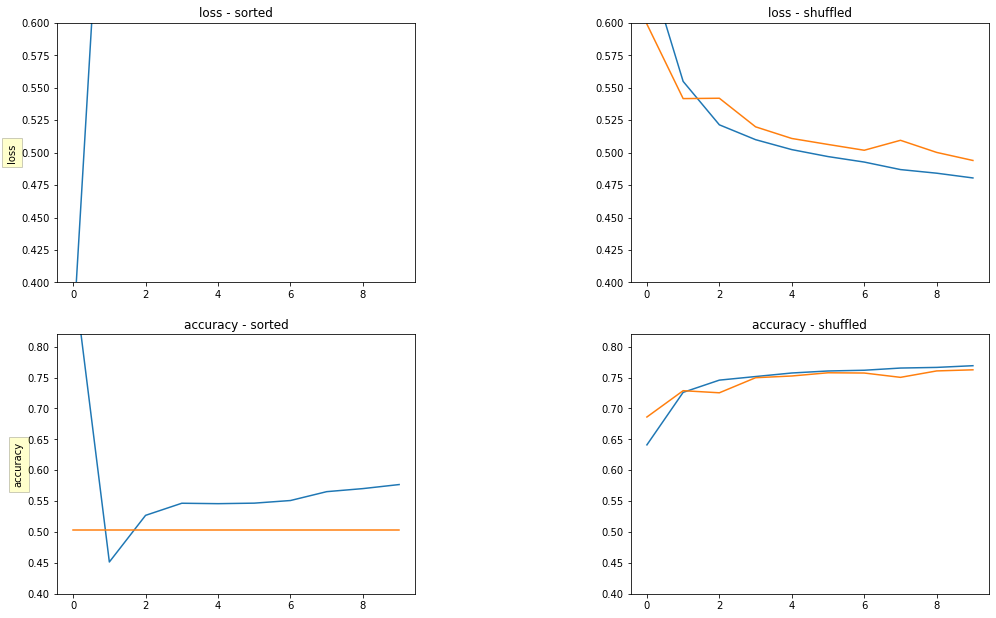

In [65]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_sorted_history,
          dan_suffled_history, 
          model_1_name='sorted',
         model_2_name='shuffled',
         y_lim_accuracy_lower=0.40,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 2.2 DAN vs Weighted Averaging Models using Attention 

#### 2.2.1. Warm-Up: Manual Attention Calculation

**QUESTION:**

2.2.1.a Calculate the context vector for the following query and key/value vectors. You can do this manually, or you can use 


```
tf.keras.layers.Attention()
```

2.2.1.b What are the weights for the key/value vectors?


In [66]:
q = [1, 2., 1]

k1 = v1 = [-1, -1, 3.]
k2 = v2 = [1, 2, -5.]


In [88]:
### YOUR CODE HERE

k_attention =  tf.keras.layers.Attention()([np.array([q]), np.array([k1,k2])])

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

scores = np.array([np.dot(q, k1), np.dot(q, k2)])
alpha = softmax(scores / np.sqrt(len(q)))
attention = (np.array(alpha[0]) * v1) + (np.array(alpha[1]) * v2)

print(f'keras: {k_attention}')
print(f'manual: {attention}')


### END YOUR CODE

keras: [[ 0.   0.5 -1. ]]
manual: [ 0.   0.5 -1. ]


#### 2.2.2 The 'WAN' Model


Next, we would like to improve our DAN by attempting to train a neural net that learns to put more weight on some words than others. How could we do that? **Attention** is the answer!

Here, we will build a model that you can call "Weighted Averaging Models using Attention". You should construct a network that uses attention to weigh the input tokens for a given example.

The core structure is the same as for the DAN network, but there are obviously some critical changes:

1) How do I create a learnable query vector for the attention calculation, that is supposed to generate the suitable token probabilities? And what is its size?

2) What are the key vectors for the attention calculation?

3) How does the averaging change? 


First, the key vectors should be the incoming word vectors.

The query vector needs to have the size of the word vectors, as it needs to attend to them. A good way to create the query vector is to generate an embedding like vector easily by getting a single row of trained weights from a Dense layer if we pass in a value of one to multiply by that weight matrix in the usual way:


```
wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
```

That sounds great... but how do I use this to have a vector available in my calculation? And... make this vector available to all examples in the batch?

What you can use is a 'fake input-like layer' that creates for each incoming batch example a '1', that then the query layer can get applied to.
Assuming that the input layer for your network is **wan_input_layer**, this could be done with

```
wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1)) 
```

You could then have the query vector available for each example through:

```
wan_query_vector = wan_query_layer(wan_batch_of_ones)

```

You will see that this structure is essentially  the same as what we did for word vectors, except that we had to replace the input layer with our fake layer, as there is no actual input. We will also have **2 outputs** (discussed in a bit.)

How does the averaging change? You should use:

```
tf.keras.layers.Attention()
```

and make sure you consider the proper inputs and outputs for that calculation.

So why 2 outputs, and how do we do that? First off, we need the output that makes the classification, as always. What is the second output? We also would like our model to provide us with the attention weights it calculated. This will tell us which words were considered how much for the context creation.

Can we implement 2 outputs? You need to have a list of the two outputs. But note that you may also want to have a list of 2 cost function and 2 metrics. You can use 'None' both times to account for our new second output, and you can ignore the corresponding values that the model report. (In general, the total loss will be a sum of the individual losses. So one would rather construct a loss that always returns zero for the second loss, but as it is very small we can ignore this here.)

Finally, you may want to reshape the output after the Attention layer, because the Attention layer will still give a sequence of vectors for each example. It will just be a sequence of one weighted average vector for each example. You may want to remove that middle dimension of size one so you just have a single vector for each example. You can do that with layers.Reshape():

```
wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)
```

In [91]:
def create_wan_model(retrain_embeddings=False, 
                     max_sequence_length=SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     learning_rate=0.001):
  """
  Construct the WAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """
  ### YOUR CODE HERE


  # start by creating the wan_embedding_layer. Use the embeddings_initializer. variable defined above.
  wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')

  wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings)
  wan_embeddings = wan_embedding_layer(wan_input_layer)

  wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
  wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
  wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
  wan_query_vector = wan_query_layer(wan_batch_of_ones)
  wan_attention_output = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings]) # without return_attention_scores=True, it gives a simple output
  wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)

  hidden_output = tf.keras.layers.Dense(hidden_dim, activation='relu',
                                              name='wan_hidden_1')(wan_attention_output)
  hidden_output = tf.keras.layers.Dropout(dropout)(hidden_output)
  
  wan_classification = tf.keras.layers.Dense(1,
                                              activation='sigmoid',
                                              name='wan_classification')(hidden_output)
  
  wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification])
  wan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                        name='Adam'),
                    metrics='accuracy')


  ### END YOUR CODE
    
  return wan_model



Now run the model for the same dataset as we did for the DAN model (shuffled data) and save it in its history 'wan_history':

In [92]:
### YOUR CODE HERE

wan_model = create_wan_model()

# use wan_history = ... below
wan_history = wan_model.fit(sorted_training_input_ids,
                          sorted_training_labels,
                          validation_data=(test_input_ids, test_input_labels),
                          batch_size=32,
                          epochs=10,
                          shuffle=True
                          )  

### END YOUR CODE

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5810 - accuracy: 0.6953 - val_loss: 0.5002 - val_accuracy: 0.7608
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4835 - accuracy: 0.7673 - val_loss: 0.4835 - val_accuracy: 0.7698
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4690 - accuracy: 0.7770 - val_loss: 0.4714 - val_accuracy: 0.7728
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4604 - accuracy: 0.7809 - val_loss: 0.4668 - val_accuracy: 0.7728
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4544 - accuracy: 0.7866 - val_loss: 0.4656 - val_accuracy: 0.7790
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4486 - accuracy: 0.7885 - val_loss: 0.4604 - val_accuracy: 0.7776
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4460 - accuracy: 0.7900 - val_loss: 0.4593 - val_accuracy: 0.7750
Epoch 

**QUESTION:**

2.2.2.a What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the wan training after 10 epochs?


Now compare the results of the initial dan_model training and the wan_model training:

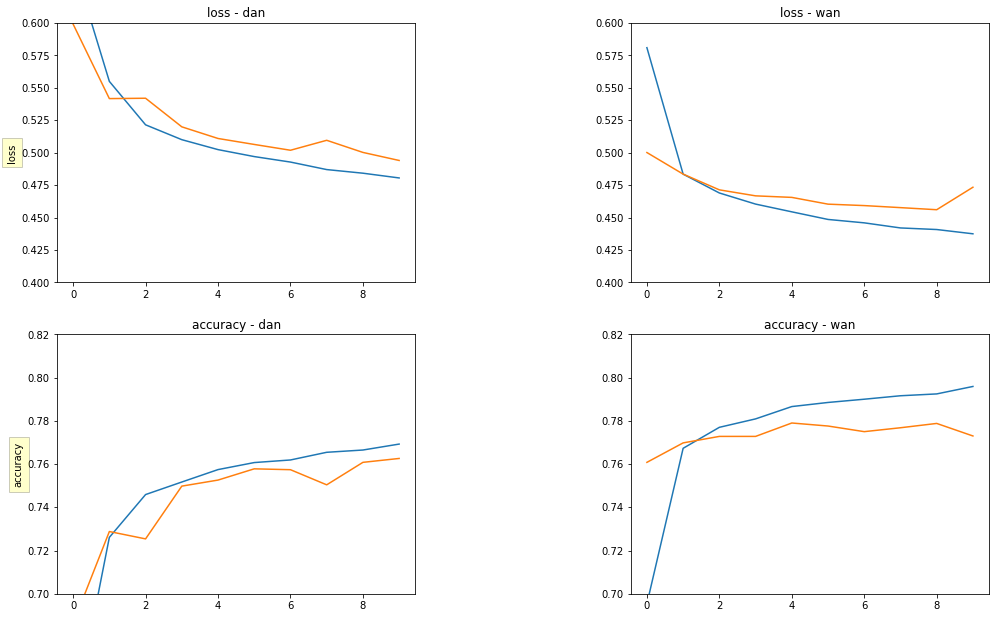

In [93]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_suffled_history,
          wan_history, 
          model_1_name='dan',
         model_2_name='wan',
         y_lim_accuracy_lower=0.70,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Next, let us see for the wan_model which words did matter for the classification and which ones did less so. How can we tell? We can look at the attention weights!

Consider just the first training example:

In [94]:
train_examples_batch[0].numpy().decode('utf-8')

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

The corresponding input ids that are suitable formatted, i.e. with max length 100, are these:

In [95]:
probe_input_ids = train_input_ids[0]
probe_input_ids

array([21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
       16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
       35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
         638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
       22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
       36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
       17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
        9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
       23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
       18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
       43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
       42958])

and the first 10 corresponding tokens are: 

In [96]:
probe_tokens = [x.decode('utf-8') for x in train_tokens[0].numpy()][:100]
probe_tokens[:10]

['This',
 'was',
 'an',
 'absolutely',
 'terrible',
 'movie.',
 "Don't",
 'be',
 'lured',
 'in']

With that first training example, identify the 5 words with the highest impact and the 5 words with the lowest impact on the score, i.e., identify the 5 words with the largest and  smallest weights, respectively. (Note that multiple occurences of the same word count separately for the exercise).

HINT: You should create a list of (word/weight) pairs, and then sort by the second argument. Python's '.sort()' function may come in handy.

In [130]:
### YOUR CODE HERE

# 'pairs' should be the variable that holds the  token/weight pairs.

wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1],
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                input_length=SEQUENCE_LENGTH,
                                trainable=False)
wan_embeddings = wan_embedding_layer(probe_input_ids)

wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
wan_batch_of_ones = tf.tile(wan_one_vector, (1, 1, 1))
wan_query_vector = wan_query_layer(wan_batch_of_ones)
attention, score = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings], return_attention_scores=True) 
pairs = list(zip(probe_tokens, score.numpy().tolist()[0][0]))
pairs.sort(key = lambda x: x[1], reverse = True)
### END YOUR CODE

print('most important tokens:')
print('\t', pairs[:10])
print('\nleast important tokens:')
print('\t', pairs[-10:])



most important tokens:
	 [('making', 0.011788860894739628), ('disappointed', 0.011565553955733776), ('devoid', 0.01151309534907341), ('cases', 0.011436526663601398), ('pathetic', 0.011358213610947132), ('pathetic', 0.011358213610947132), ('Even', 0.011181417852640152), ('acting', 0.010986068286001682), ('Both', 0.010926397517323494), ('terrible', 0.010892104357481003)]

least important tokens:
	 [('an', 0.009155016392469406), ('an', 0.009155016392469406), ('this', 0.009117533452808857), ('this', 0.009117533452808857), ('am', 0.009105588309466839), ('for', 0.009103191085159779), ('are', 0.008919455111026764), ('are', 0.008919455111026764), ('emotional', 0.008874990977346897), ('Maria', 0.008758707903325558)]


 **QUESTION:**

 2.2.2.b List the 5 most important words, with the most important first. (Again, if a word appears twice, note it twice.)

 2.2.2.c List the 5 least important words, with the most important of those first. (Again, if a word appears twice, note it twice.)

### 2.3 Approaches for Training of Embeddings

Rerun the DAN Model in 3 configurations:


1.   embedding_initializer = 'word2vec' and retrain_embeddings=False
2.   embedding_initializer = 'word2vec' and retrain_embeddings=True
3.   embedding_initializer = 'uniform' and retrain_embeddings=True


**NOTE:** Train the models with static embeddings for 10 epochs and the ones with trainable embeddings for 3 epochs. 

What do you observe?



In [132]:
### YOUR CODE HERE
print('Static model')
static_model = create_dan_model(embedding_initializer = 'word2vec', retrain_embeddings=False)                                                      
static_history = static_model.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )  

print('word2vec with retrain')
word2vec_retrain = create_dan_model(embedding_initializer = 'word2vec', retrain_embeddings=True)                                                      
word2vec_retrain_hist = word2vec_retrain.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=3,
                            shuffle=True
                            )
print('uniform with retrain')
uniform_retrain = create_dan_model(embedding_initializer = 'uniform', retrain_embeddings=True)                                                      
uniform_retrain_hist = word2vec_retrain.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=3,
                            shuffle=True
                            )  
### END YOUR CODE

Static model
Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6493 - accuracy: 0.6407 - val_loss: 0.6029 - val_accuracy: 0.7046
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5637 - accuracy: 0.7219 - val_loss: 0.5516 - val_accuracy: 0.7228
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5288 - accuracy: 0.7418 - val_loss: 0.5305 - val_accuracy: 0.7422
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5156 - accuracy: 0.7490 - val_loss: 0.5203 - val_accuracy: 0.7426
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5075 - accuracy: 0.7531 - val_loss: 0.5136 - val_accuracy: 0.7502
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5014 - accuracy: 0.7576 - val_loss: 0.5083 - val_accuracy: 0.7584
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4958 - accuracy: 0.7620 - val_loss: 0.5070 - val_accuracy: 

**QUESTION:**

2.3.a What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the static model after 10 epochs?

In [139]:
### YOUR CODE HERE
max(static_history.history['val_accuracy'])

### END YOUR CODE

0.7588000297546387

**QUESTION:**


2.3.b What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the model where you initialized with word2vec vectors but allow them to retrain for 3 epochs?



In [140]:
### YOUR CODE HERE
max(word2vec_retrain_hist.history['val_accuracy'])

### END YOUR CODE

0.7893999814987183

**QUESTION:**

2.3.c What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the model where you initialized randomly and then trained?




In [141]:
max(uniform_retrain_hist.history['val_accuracy'])


0.7681999802589417


##3. BERT-based Classification Models

Now we turn to classification with BERT. We will perform classifications with various models that are based on pre-trained BERT models.


### 3.1. Basics

Let us first explore some basics of BERT. 

You first need to define the tokenizer and the model for the pre-trained configuration you need.

We already got the tokenizer during setup with:

```
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
```

Now, we also need to get the model:

In [142]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(Ignore the warnings.)

Next, consider this input:

In [143]:
test_input = ['this bank is closed on Sunday', 'the steepest bank of the river is dangerous']

Now apply the tokenizer to tokenize it:

In [144]:
tokenized_input = bert_tokenizer(test_input, 
                                 max_length=12,
                                 truncation=True,
                                 padding='max_length', 
                                 return_tensors='tf')

tokenized_input

{'input_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[ 101, 1142, 3085, 1110, 1804, 1113, 3625,  102,    0,    0,    0,
           0],
       [ 101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249,  102,
           0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int32)>}

 **QUESTION:** 
 
 3.1.a  Why do the attention_masks have 4 and 1 zeros, respectively?

  * For the first example the last four tokens belong to a different segment. For the second one it is only the last token.

  *  For the first example 4 positions are padded while for the second one it is only one.

------


Next, let us look at the BERT outputs for these 2 sentences:

In [ ]:
while True:
  print(2)
  time.sleep(500)

In [ ]:
### YOUR CODE HERE

# bert_output = ...


### END YOUR CODE

 **QUESTION:** 
 
 3.1.b How many outputs are there?

 3.1.c Which output do we need to use to get token-level embeddings?

 * the first
 
 * the second 

 3.1.d Which token index number corresponds to 'bank' in the first sentence? ('bert_tokenizer.tokenize()' may come in handy.. and don't forget the CLS token! )

 3.1.e Which token index number corresponds to 'bank' in the second sentence?

 3.1.f What is the cosine similarity between the BERT outputs for the two occurances of 'bank' in the two sentences?

 3.1.g How does this relate to the cosine similarity of 'this' (in sentence 1) and the first 'the' (in sentence 2). Compute the cosine similarity.

 Enter your code below.

In [ ]:
### YOUR CODE HERE

#1. -> print it out


#2. -> answer in answer file

#3. -> Look at tokenization


#4. -> Look at tokenization


#5.  -> get the vectors and calculate cosine similarity



#6.  -> get the vectors and calculate cosine similarity


### END YOUR CODE

### 3.2 CLS-Token-based Classification 

In the live session we discussed classification with BERT using the pooled token. We now will do the same but extract the [CLS] token output for each example and use that for classification purposes.

Consult the model from the live session and change accordingly.

**HINT:**
You will want to extract the output of the [CLS] token from the BERT output similarly to what we did above to get the output for 'bank', etc.


In [ ]:
def create_bert_cls_model(hidden_size = 100, 
                          dropout=0.3,
                                learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    ### YOUR CODE HERE









    

    ### END YOUR CODE
    
    return classification_model

Now create the model and run for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We don't make a distinction here.)


In [ ]:
### YOUR CODE HERE



### END YOUR CODE

 **QUESTION:** 
 
 3.2.a What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the [CLS]-classification model after training for 2 epochs?


 

### 3.3 Classification by Averaging the BERT outputs

Instead of using the [CLS] token, we will now average all of the output tokens that correspond to actual tokens. I.e., ignore the [CLS] and [SEP] tokens. Where are they? First and last for us.


**HINT:**
You will want to extract all of the relevant tokens and then apply an average across the tokens. You may want to use:


```
tf.math.reduce_mean()
```
but you can also do it in other ways.



In [ ]:
def create_bert_avg_model(hidden_size = 100, 
                                dropout=0.3,
                                learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE





 



    
    
    ### END YOUR CODE

    return classification_model

Now create the model and run for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We don't make a distinction here.)

In [ ]:
### YOUR CODE HERE



### END YOUR CODE

 **QUESTION:** 
 
 3.3.a What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the BERT-averaging-classification model after training for 2 epochs?


 

### 3.4 Adding a CNN on top of BERT

Can we also combine advanced architectures? Why not! I the end we deal with tensors and it does not matter whether they are coming from static word embeddings or context-based embeddings coming from BERT. (Whether we want to is another question, but let's try it here.)


**HINT:**
You should appropriately stitch together the BERT-based components and the CNN components from the lesson notebook. Keep the same parameters, but set dropout to 0.3.

In [ ]:
def create_bert_cnn_model(hidden_size = 100, 
                                learning_rate=0.00005,
                                num_filters = [100, 100, 50, 25],
                                kernel_sizes = [3, 5, 10, 20],
                                dropout = 0.3):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    ### YOUR CODE HERE
    











    

    ### END YOUR CODE
    
    return classification_model

Run this model for 2 epochs as well:

In [ ]:
### YOUR CODE HERE


### END YOUR CODE

 **QUESTION:** 
 
3.4.a What (in percent (e.g. 0.651 = 65.1)) is the highest validation accuracy that you observed for the BERT-CNN-classification model after 2 epochs?


# That's It! 
## Congratulations... You are Done! 
## We hope you learned a ton!